In [208]:
from matplotlib import pyplot as plt
from mnist1d.data import make_dataset, ObjectView
from torch import nn

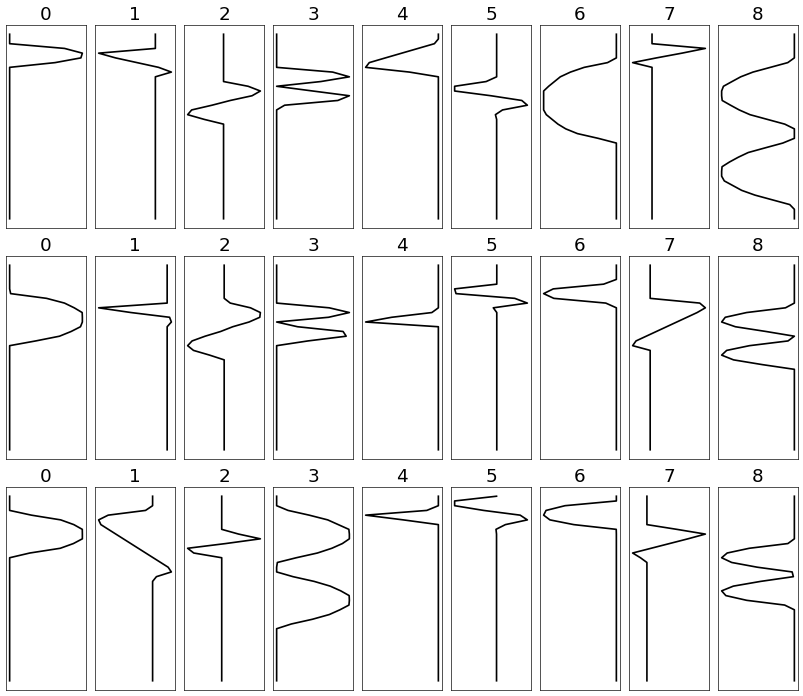

In [206]:
def select_samples(xs, ys, num):
    buckets = {i: [] for i in range(10)}
    class_counts = {i: 0 for i in range(10)}

    for x, y in zip(xs, ys):
        if class_counts[y] < num:
            buckets[y].append(x)
            class_counts[y] += 1

            if all(count == num for count in class_counts.values()):
                break

    selected_xs = [x for digit in range(10) for x in buckets[digit]]
    selected_ys = [digit for digit in range(10) for _ in buckets[digit]]

    return selected_xs, selected_ys


def visualize_mnist_1d(xs, ys, t, num=3):
    xs, ys = select_samples(xs, ys, num=num)

    rows, cols = 3, 9
    ratio = 2.6
    fig = plt.figure(figsize=[cols * 1.5, rows * 1.5 * ratio], dpi=60)

    for r in range(rows):
        for c in range(cols):
            ix = c * rows + r
            x = xs[ix]
            ax = fig.add_subplot(rows, cols, r * cols + c + 1)

            ax.plot(x, t, 'k-', linewidth=2)
            ax.set_title(str(ys[ix]), fontsize=22)

            ax.invert_yaxis()
            ax.set_xticks([]), ax.set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()
    plt.show()


dataset_args = ObjectView({
    'num_samples': 50,
    'train_split': 0.8,
    'template_len': 12,
    'padding': [0, 100],
    'scale_coeff': 0,
    'max_translation': 30,
    'corr_noise_scale': 0,
    'iid_noise_scale': 0,
    'shear_scale': 0,
    'shuffle_seq': False,
    'final_seq_length': 40,
    'seed': 42,
})

data = make_dataset(dataset_args)

x, y, t = data['x'], data['y'], data['t']

visualize_mnist_1d(x, y, t)

In [223]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        channels = 25
        self.conv1 = nn.Conv1d(1, channels, 5, stride=2, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.linear = nn.Linear(125, 10)
        # flattened channels -> 10 (assumes input has dim 50)

    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])

    def forward(self, x):
        x = x.view(-1, 1, x.shape[-1])
        h1 = self.conv1(x).relu()
        h2 = self.conv2(h1).relu()
        h3 = self.conv3(h2).relu()
        h3 = h3.view(h3.shape[0], -1)
        return self.linear(h3)


model = CNNModel()
print(f'parameters: {model.count_params()}')
print(model)

parameters: 5210
CNNModel(
  (conv1): Conv1d(1, 25, kernel_size=(5,), stride=(2,), padding=(1,))
  (conv2): Conv1d(25, 25, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(25, 25, kernel_size=(3,), stride=(2,), padding=(1,))
  (linear): Linear(in_features=125, out_features=10, bias=True)
)
